# Surface-Wave Tomography

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/sw_tomography/sw_tomography.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

# Theoretical Background

We assume surface waves propagate, from a given point on the Earth's surface to another, without deviating from the great-circle path connecting them. Under this assumption, the travel time between these two points is $t = \int_{\mathrm{path}}{s(\phi(l), \theta(l)) dl}$, 
where $\phi$ and $\theta$ denote longitude and latitude, and $s$ the Earth's slowness.

If we discretize the Earth's surface through $n$ blocks (or grid cells) of constant slowness, the forward equation for the average slowness associated with the $i$th station pair reads 
\begin{equation}
\tag{1}
s_i = \frac{1}{L_i} \sum_{j}^n {s_j l_j},
\end{equation}
where $L_i$ denotes the great-circle distance and $\frac{l_j}{L_i}$ the fraction of the great-circle path crossing the $j$th block. By defining the $m \times n$ matrix such that $A_{ij} = \frac{l_j}{L_i}$, we can switch to matrix notation and write

\begin{equation}
\tag{2}
{\bf A \cdot x} = {\bf d},
\end{equation}

where $\bf d$ is the $m$-vector whose $i$th entry corresponds to the measured inter-station slowness, and $\bf x$ the sought $n$-vector whose $j$th element corresponds to the model coefficient $s_j$. 

# Data and Imports

In this notebook, we utilize CoFI to estimate lateral variations in Rayleigh-wave velocity across Australia at the surface-wave period of 5 s. We use the data set collected by [Magrini et al. (2023)](https://doi.org/10.1029/2023JB026688), consisting of 15,661 measurements of average inter-station phase-velocity. These data, along with the data kernel $\mathbf{A}$ corresponding to a fine discretization of Australia consisting of 11,916 pixels of $0.3^\circ \times 0.3^\circ$, are imported in this notebook through the SurfaceWaveTomography class of the [Espresso](https://github.com/inlab-geo/espresso) library. 

# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso seislib

In [1]:
import numpy as np
import scipy

import bayesbay as bb
from espresso import SurfaceWaveTomography
import cofi

# Imports for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.patches import PathPatch
import matplotlib.tri as tri
import cartopy.crs as ccrs
from cartopy.mpl.patch import geos_to_path

from shapely import Polygon, Point, box
from seislib.tomography import EqualAreaGrid
from seislib.utils import scatter_to_mesh
from seislib.plotting import make_colorbar, scientific_label
from seislib.plotting import plot_map as _plot_map
import seislib.colormaps as scm

In [2]:
espresso_dict = SurfaceWaveTomography(example_number=3).example_dict
grid = espresso_dict['grid']
grid_points = np.column_stack(grid.midpoints_lon_lat())
A = espresso_dict['jacobian']
polygon = Polygon(espresso_dict['polygon'])

d_obs = 1000 * espresso_dict['slowness']

# Approach I: Regularized Least-Squares

Since the $15661 \times 11916$ matrix $\mathbf{A}$ is not invertible, the system of linear equations (2) is ill-conditioned and it is not possible to find an exact solution for $\bf x$. In this section, we overcome this issue by inverting for the regularized least-squares solution

\begin{equation}
\tag{3}
{\bf x} = {\bf x}_0 + \left( {\bf A}^T \cdot {\bf A} + \mu^2 {\bf R}^T \cdot {\bf R} \right)^{-1} \cdot {\bf A}^T \cdot ({\bf d}_{\mathrm{obs}} - {\bf A} \cdot {\bf x}_0),
\end{equation}
where we assumed that the target slowness model is approximately known, i.e. ${\bf x}_0 \sim \bf{x}$. In the above expression, the roughness operator $\bf R$ depends on the discretization and the damping coefficient $\mu$ should be chosen via L-curve analysis. For technical details about the computation of $\bf R$, see [Magrini et al. (2022)](https://doi.org/10.1093/gji/ggac236).

In [3]:
x0 = np.full(A.shape[1], 1 / 3.0) # Starting model
r = d_obs - A @ x0 # residuals
R = espresso_dict['roughness_operator']
# regularization = cofi.utils.QuadraticReg(np.array(R.todense()), (A.shape[1],))
regularization = cofi.utils.QuadraticReg(R, (A.shape[1],))

## CoFI Problem and Options

In [4]:
def get_cofi_problem_least_squares(mu):
    global A, R, r

    problem = cofi.BaseProblem()
    problem.set_data(r) # our data are now the residuals defined above
    problem.set_jacobian(A)
    problem.set_regularization(mu * regularization, mu * regularization.matrix)   # L2 norm of R, i.e. R.T @ R
    return problem

def get_cofi_options_least_squares():
    options = cofi.InversionOptions()
    options.set_tool("scipy.sparse.linalg")
    options.set_params(algorithm="minres")
    return options

def least_squares_solution(mu, verbose=True):
    problem = get_cofi_problem_least_squares(mu)
    options = get_cofi_options_least_squares()
    inv = cofi.Inversion(problem, options)
    inv_results = inv.run()
    if verbose:
        inv.summary()
    return 1 / ( inv_results.model + x0 ) # Phase velocity

## Tentative least-squares solution

In [5]:
c_tentative = least_squares_solution(0.15)

Summary for Inversion
Completed with the following result:

Summary for inversion result
SUCCESS
model: [-0.00194395 -0.00193872 -0.00193308 ... -0.01276784 -0.01276434
 -0.01276086]
info: 0
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `<class 'cofi.tools._scipy_sparse_lstsq.ScipySparseLstSq'>` - SciPy's sparse linear system solvers for solving linear problems
References: ['https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#solving-linear-problems']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: 
algorithm = minres
Use `suggest_solver_params()` to check required/optional solver-specific parameters.
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: BaseProblem
Model shape: Unknown
List of functions/properties

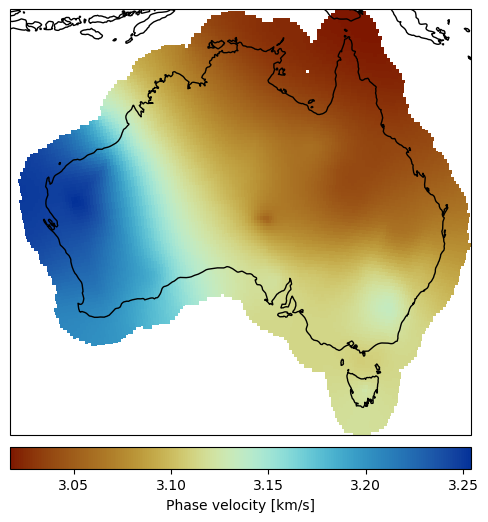

In [6]:
def plot_map(phase_velocity):
    global map_boundaries, transform
    """Plot a phase-velocity map on an equal-area grid"""
    proj = ccrs.LambertConformal(central_longitude=135,
                                 central_latitude=-27,
                                 cutoff=80,
                                 standard_parallels=(-18, -36)
                                  )
    fig = plt.figure(figsize=(5, 6.5))
    ax = plt.subplot(111, projection=proj)
    ax.coastlines()
    img, cb = _plot_map(grid.mesh, phase_velocity, ax=ax, cmap=scm.roma, show=False)
    cb.set_label('Phase velocity [km/s]')
    ax.set_extent(map_boundaries, crs=transform)
    plt.tight_layout()
    plt.show()

# Variables for plotting across the notebook
proj = ccrs.LambertConformal(central_longitude=135,
                             central_latitude=-27,
                             cutoff=80,
                             standard_parallels=(-18, -36)
                              )
transform = ccrs.PlateCarree()
map_boundaries = [113, 153, -45, -8]

plot_map(c_tentative)

## L-curve analysis

Due to a roughness-damping coeffient larger than ideal, the phase-velocity map shown above appears too smooth. In this section, we will carry out an L-curve analysis to select a more meaningful coefficient $\mu$.

In [7]:
def callback_func(inv_result, i):
    global A, x0, regularization, d_obs, damping_coeffs
    x = inv_result.model
    d_pred = A @ (x + x0)
    residual_norm = np.linalg.norm(d_obs - d_pred)
    reg_norm = np.sqrt(regularization(x))
    print(f"Finished inversion with mu={damping_coeffs[i]}")
    print(f"\tRes. Norm: {round(residual_norm, 5)}, Reg. Norm {round(reg_norm, 5)}")
    return residual_norm, reg_norm
    

damping_coeffs = np.logspace(-3, 2, 15)
lcurve_problems = []
for mu in damping_coeffs:
    problem = get_cofi_problem_least_squares(mu)
    lcurve_problems.append(problem)

inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=lcurve_problems,
    list_of_inv_options=get_cofi_options_least_squares(),
    callback=callback_func,
    parallel=False
)
all_res, all_cb_returns = inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with mu=0.001
	Res. Norm: 0.65182, Reg. Norm 262.32953
Finished inversion with mu=0.0022758459260747888
	Res. Norm: 0.71953, Reg. Norm 154.79492
Finished inversion with mu=0.005179474679231213
	Res. Norm: 0.83623, Reg. Norm 86.42188
Finished inversion with mu=0.011787686347935873
	Res. Norm: 1.00218, Reg. Norm 44.76517
Finished inversion with mu=0.02682695795279726
	Res. Norm: 1.20775, Reg. Norm 21.78613
Finished inversion with mu=0.0610540229658533
	Res. Norm: 1.4301, Reg. Norm 9.46193
Finished inversion with mu=0.13894954943731375
	Res. Norm: 1.61895, Reg. Norm 4.86351
Finished inversion with mu=0.31622776601683794
	Res. Norm: 2.04841, Reg. Norm 2.66939
Finished inversion with mu=0.7196856730011522
	Res. Norm: 2.67267, Reg. Norm 0.7842
Finished inversion with mu=1.6378937069540647
	Res. Norm: 2.90171, Reg. Norm 0.16478
Finished inversion with mu=3.7275937203149416
	Res. Norm: 2.95201, Reg. Norm 0.03225
Finished inversion with mu=8.483428982440726
	Res. Norm: 2.9619

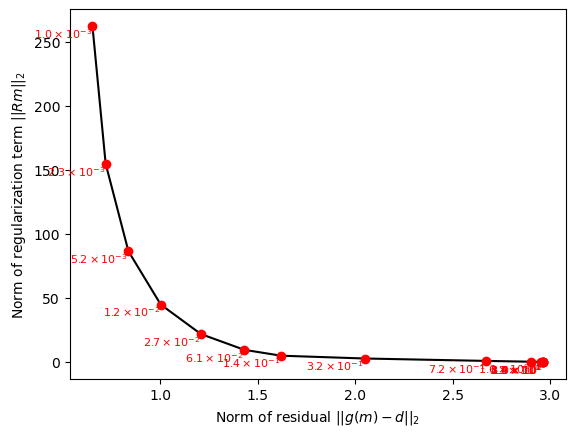

In [8]:
residual_norm, regularization_norm = np.array(l_curve_points)
plt.plot(residual_norm, regularization_norm, 'k.-')
plt.xlabel(r'Norm of residual $||g(m)-d||_2$')
plt.ylabel(r'Norm of regularization term $||Rm||_2$')
for damping, res_norm, reg_norm in zip(damping_coeffs, 
                                       residual_norm, 
                                       regularization_norm):
    plt.plot(res_norm, reg_norm, 'ro')
    plt.text(res_norm - res_norm*2e-3, 
             reg_norm - reg_norm*2e-3, 
             s=r'$%s$'%scientific_label(damping, 1), 
             va='top', 
             ha='right', 
             fontsize=8,
             color='r')

## Least-squares solution with selected damping coefficient

Summary for Inversion
Completed with the following result:

Summary for inversion result
SUCCESS
model: [-0.00024124 -0.00024586 -0.00025341 ... -0.008942   -0.00894866
 -0.00894108]
info: 0
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
Backend tool: `<class 'cofi.tools._scipy_sparse_lstsq.ScipySparseLstSq'>` - SciPy's sparse linear system solvers for solving linear problems
References: ['https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#solving-linear-problems']
Use `suggest_tools()` to check available backend tools.
Solver-specific parameters: 
algorithm = minres
Use `suggest_solver_params()` to check required/optional solver-specific parameters.
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: BaseProblem
Model shape: Unknown
List of functions/properties

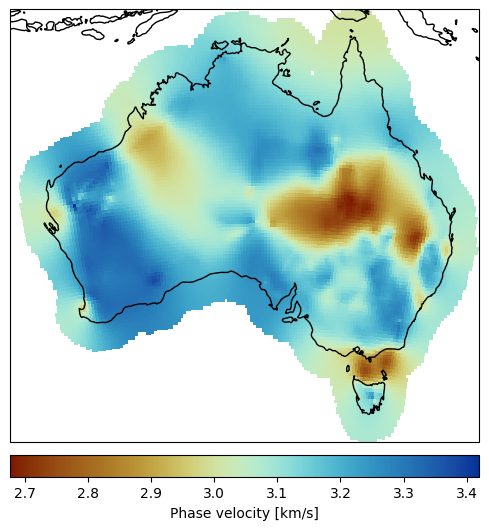

In [9]:
c = least_squares_solution(1e-2)
plot_map(c)

The above phase-velocity map aligns with that in [Magrini et al. (2023)](https://doi.org/10.1029/2023JB026688).

# Approach II: Trans-dimensional Bayesian Inversion

In this section, we use CoFI to estimate lateral variations in phase velocity across Australia via reversible-jump Markov chain Monte Carlo (RJ-MCMC) sampling ([Green 1995](https://doi.org/10.1093/biomet/82.4.711)). RJ-MCMC is is a generalization of the Metropolis-Hastings algorithm allowing for trans-dimensional parameterizations. The algorithm starts from an initial model $\mathbf{m}$ and proposes a new model $\mathbf{m}'$ based on a perturbative approach. The new model is then accepted (in which case, $\mathbf{m} \gets \mathbf{m'}$) with probability
\begin{equation}
\tag{4}
\alpha(\mathbf{m'} \mid \mathbf{m}) = 
    \underbrace{\frac{p(\mathbf{d} \mid \mathbf{m'})}{p(\mathbf{d} \mid \mathbf{m})}}_{\text{Likelihood ratio}}
    \underbrace{\frac{p(\mathbf{m'})}{p(\mathbf{m})}}_{\text{Prior ratio}}
    \underbrace{\frac{q(\mathbf{m} \mid \mathbf{m'})}{q(\mathbf{m'} \mid \mathbf{m})}}_{\text{Proposal ratio}} 
    |\mathbf{J}|,
\end{equation}
where $p(a \mid b)$ denotes the conditional probability of $a$ given $b$ and it is understood that $\alpha = \min(1, \alpha)$. In the above expression, the Jacobian $\mathbf{J}$ of the transformation from $\mathbf{m}$ to $\mathbf{m}'$ accounts for the volume change in the parameter space under the proposed transformation. Through the forward operator $\mathbf{g}$, the likelihood expresses how well a model explains the data, and reads
\begin{equation}
\tag{5}
p(\mathbf{d} | \mathbf{m}) = \frac{1}{\sqrt{(2\pi)^n |\mathbf{C}_d|}} \ \exp \left\{\frac{-\Phi(\mathbf{m})}{2} \right\},
\end{equation}
where $n$ denotes the size of the data vector, $\mathbf{C}_d$ the data covariance matrix, and
\begin{equation}
\tag{6}
\Phi(\mathbf{m}) = \left[ \mathbf{g}(\mathbf{m}) - \mathbf{d} \right]^T \mathbf{C}_d^{-1} \left[ \mathbf{g}(\mathbf{m}) - \mathbf{d} \right]
\end{equation}
is the Mahalanobis distance between observations and model predictions. 

In MCMC methods, the process of proposing a new model and deciding whether to accept it is repeated many times to build a sequence of models $\mathcal{M} = \{\mathbf{m}_t\}$, where $t$ denotes the Markov chain iteration. In practice, a \textit{burn-in period} typically precedes the generation of $\mathcal{M}$ to allow convergence of the Markov chain to a stationary distribution. Once the burn-in period is completed, the subsequent iterations are used to populate $\mathcal{M}$, providing an approximation to the posterior distribution
\begin{equation}
\tag{7}
p(\mathbf{m} \mid \mathbf{d}) \propto p(\mathbf{d} \mid \mathbf{m}) p(\mathbf{m}).
\end{equation}

In the following, we will sample the posterior using the [BayesBay](https://bayes-bay.readthedocs.io/en/latest/) library, which we will select through the cofi.InversionOptions class.

## Parameterization

We discretize the Earth's surface using a trans-dimensional Voronoi tessellation, with each Voronoi cell corresponding to a phase-velocity value defined by a uniform prior between 2 and 4 km/s.

In [9]:
vel = bb.prior.UniformPrior('vel', vmin=2, vmax=4, perturb_std=0.1)
voronoi = bb.discretization.Voronoi2D(
    name='voronoi', 
    polygon=polygon, 
    perturb_std=1, 
    n_dimensions_min=100, # Minimum number of Voronoi cells
    n_dimensions_max=1500, # Maximum number of Voronoi cells
    parameters=[vel], # Each cell has a value of phase velocity
    compute_kdtree=True) # This stores a kd-tree for interpolating the Voronoi tessellation onto the equal-area grid we used earlier
parameterization = bb.parameterization.Parameterization(voronoi)

## Data and Likelihood

We treat the data noise as unknown by parameterizing the data covariance matrix $\mathbf{C}_d = \sigma^2 \mathbf{I}$ through the noise standard deviation $\sigma$, which is assigned a uniform prior distribution within the range 0--0.01 s/km.

Note that, different from the previous section, obtaining forward predictions $\mathbf{d}_{\mathrm{pred}}$ presents two main challenges when using a trans-dimensional Voronoi tessellation (e.g., [Sambridge & Guđmundsson 1998](https://doi.org/10.1029/97JB02602)). First, there are no analytical expressions for the intersections of a great-circle path with Voronoi cell boundaries, complicating the calculation of $l_j$ in eq. (1). Second, such intersections must be recomputed whenever the discretization is perturbed, which becomes increasingly expensive as the number of station pairs increases.

To address these issues, we will interpolate the phase velocity in each Voronoi cell onto the equal-area grid used in the previous section, thereby enabling the use of the matrix $\mathbf{A}$ to obtain forward predictions. This behaviour is programmed in the function `_forward`, as defined below.

In [10]:
def _forward(kdtree, vel):
    global A, grid_points
    nearest_neighbors = kdtree.query(grid_points)[1]
    interp_vel = vel[nearest_neighbors]
    return interp_vel, A @ (1 / interp_vel)


def forward(state):
    voronoi = state["voronoi"] # Voronoi nuclei
    kdtree = voronoi.load_from_cache('kdtree') # Load the kd-tree for interpolation
    interp_vel, d_pred = _forward(kdtree, voronoi.get_param_values('vel')) # Velocity model and dpred
    state.save_to_extra_storage('interp_vel', interp_vel) # Save velocity model for plotting later
    return d_pred


target = bb.Target('d_obs', 
                   d_obs, 
                   std_min=0, # Minimum noise standard deviation
                   std_max=0.01, # Maximum noise standard deviation
                   std_perturb_std=0.001, # Standard deviation of the Gaussian used to perturb sigma
                   noise_is_correlated=False)
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=forward)

## CoFI Options and Bayesian Sampling

We sample the posterior via 12 Markov chains. We run each chain for 350,000 iterations, and save one model every 100 starting from the 150,000th iteration.

In [ ]:
def get_cofi_options_bayesian(n_chains, n_iterations, burnin_iterations, save_every):
    starting_states = []
    for _ in range(n_chains):
        starting_states.append(parameterization.initialize()) # Randomly initialize Voronoi cells
        log_likelihood.initialize(starting_states[-1]) # Evaluate the likelihood associated with the initial state

    # Get the perturbation functions: Perturbation of phase velocity/Voronoi nuclei/noise and birth/death
    perturbation_funcs = parameterization.perturbation_funcs 
    
    inv_options = cofi.InversionOptions()
    inv_options.set_tool("bayesbay")
    inv_options.set_params(
        walkers_starting_states=starting_states,
        perturbation_funcs=perturbation_funcs,
        log_like_ratio_func=log_likelihood,
        n_chains=n_chains, 
        n_iterations=n_iterations, 
        burnin_iterations=burnin_iterations,
        verbose=False, 
        save_every=save_every, 
    )
    return inv_options

inv = cofi.Inversion(cofi.BaseProblem(), 
                     get_cofi_options_bayesian(n_chains=12,
                                               n_iterations=350_000,
                                               burnin_iterations=150_000,
                                               save_every=100))
inv_results = inv.run()

In [13]:
# Get the results
saved_states = inv_results.models
statistics = {"mean": np.mean(saved_states['interp_vel'], axis=0),
              "std": np.std(saved_states['interp_vel'], axis=0),
              "std_noise": saved_states['d_obs.std']}

## Plotting a Voronoi tessellation in geographic coordinates

In [14]:
def plot_tessellation_geographic(voronoi_sites, 
                                 param_values=None, 
                                 clip_polygon=None, 
                                 ax=None, 
                                 colorbar=True, 
                                 vmin=None, 
                                 vmax=None, 
                                 norm=None, 
                                 cmap='viridis'):
    """
    Plots a Voronoi tessellation within a specified geographic polygon.
    
    :param voronoi_sites: Coordinates of the Voronoi sites.
    :param param_values: Parameter values for coloring the Voronoi cells.
    :param clip_polygon: The geographic boundary to clip the Voronoi tessellation.
    :param ax: The matplotlib axis to plot on. Creates a new axis if None.
    :param colorbar: Flag to indicate if a colorbar should be plotted.
    :param vmin: The minimum value for the colormap normalization.
    :param vmax: The maximum value for the colormap normalization.
    :param norm: A matplotlib.colors.Normalize instance for normalizing the color mapping.
    :param cmap: The colormap for the Voronoi cells.
    :return: The matplotlib axis and colorbar (if created).
    """
    # Extend the Voronoi sites with boundary points to enclose the tessellation.
    boundary_points = np.array([[180, 90], [-180, 90], [180, -90], [-180, -90]])
    sites = np.append(voronoi_sites, boundary_points, axis=0)
    vor = scipy.spatial.Voronoi(sites)

    # Sort and map the parameter values to the original Voronoi sites.
    if param_values is not None:
        isort = [np.flatnonzero(np.all(p == vor.points, axis=1)).item() for p in voronoi_sites]
        param_values = param_values[isort]
        vmin = vmin or min(param_values)
        vmax = vmax or max(param_values)
        norm = norm or mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap) if isinstance(cmap, str) else cmap
        colors = cmap(norm(param_values))
    else:
        colors = None

    # Configure the map projection and axis.
    proj = ccrs.LambertConformal(central_longitude=135, 
                                 central_latitude=-27, 
                                 cutoff=30, 
                                 standard_parallels=(-18, -36))
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

    # Plot the Voronoi cells, clipped by the specified polygon.
    for ipoint, iregion in enumerate(vor.point_region):
        region = vor.regions[iregion]
        if -1 not in region and region:
            polygon = Polygon([vor.vertices[i] for i in region])
            color = colors[ipoint] if colors is not None else 'none'
            plot_polygon(ax, polygon, clip_polygon, color)

    # Add a colorbar if requested.
    cbar = plot_colorbar(ax, cmap, norm) if colorbar and param_values is not None else None

    return ax, cbar

def plot_polygon(ax, polygon, clip_polygon, color):
    """
    Clips a Voronoi polygon to the specified geographic boundary and plots it.
    """
    if clip_polygon is not None:
        polygon = polygon.intersection(clip_polygon)
        if polygon.is_empty:
            return
        polygons = [polygon] if isinstance(polygon, Polygon) else polygon.geoms
    else:
        polygons = [polygon]

    for geom in polygons:
        ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='black', lw=0.5)

def plot_colorbar(ax, cmap, norm):
    """
    Adds a colorbar to the plot.
    """
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for scalar mappable
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    return cbar

In [15]:
grid_coarse = EqualAreaGrid(cell_size=0.35,
                            lonmin=110,
                            lonmax=157,
                            latmin=-48,
                            latmax=-4,
                            verbose=False)
idx_in_polygon = grid_coarse.indexes_in_polygon(polygon)
grid_coarse.select_cells(idx_in_polygon, inplace=True)
grid_points_coarse = np.column_stack(grid_coarse.midpoints_lon_lat())


inferred_vel = scatter_to_mesh(grid_points[:, 1], 
                               grid_points[:, 0], 
                               statistics['mean'], 
                               grid_coarse.mesh)
notnan = np.flatnonzero(~np.isnan(inferred_vel))
grid_points_coarse = grid_points_coarse[notnan]
inferred_vel = inferred_vel[notnan]
inferred_std = scatter_to_mesh(grid_points[:, 1], 
                               grid_points[:, 0], 
                               statistics['std'], 
                               grid_coarse.mesh)[notnan]

triang = tri.Triangulation(*grid_points_coarse.T)
lons_triang = grid_points_coarse[:,0][triang.triangles].mean(axis=1) 
lats_triang = grid_points_coarse[:,1][triang.triangles].mean(axis=1) 
mask = np.array([not polygon.contains(Point(lon, lat)) \
                 for lon, lat in zip(lons_triang, lats_triang)])
triang.set_mask(mask)

In [16]:
inverse_mask = box(-180, -90, 180, 90).difference(polygon)
path = geos_to_path(inverse_mask)[0]

## Plotting RJ-MCMC samples

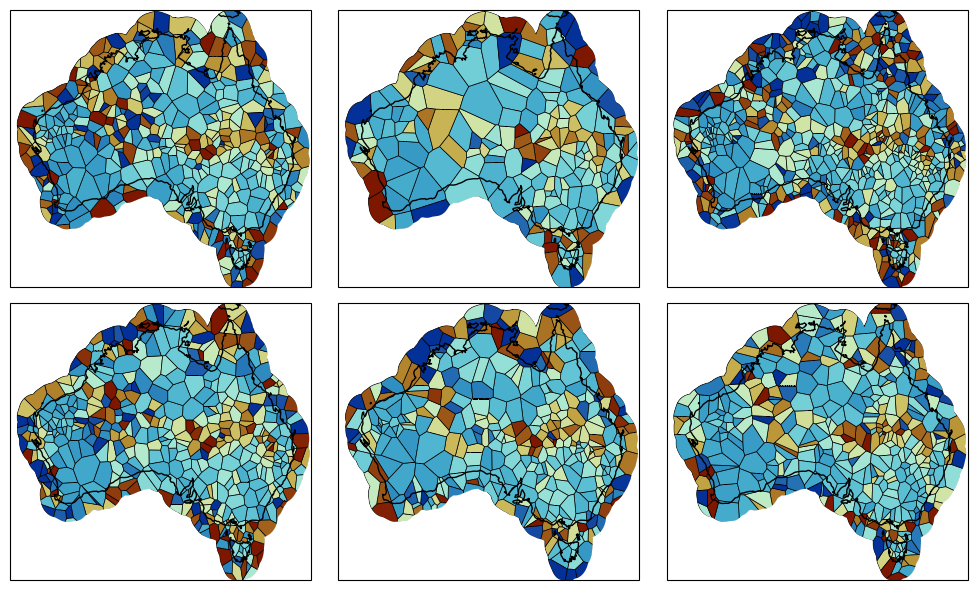

In [17]:
fig = plt.figure(figsize=(10, 6))

for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i, projection=proj)
    random_index = np.random.choice(range(len(saved_states['voronoi.vel'])), 
                                    replace=False)
    voronoi_sites = saved_states['voronoi.discretization'][random_index] 
    velocity = saved_states['voronoi.vel'][random_index] 
    ax, cbar = plot_tessellation_geographic(voronoi_sites, 
                                            velocity, 
                                            ax=ax, 
                                            cmap=scm.roma, 
                                            clip_polygon=polygon,
                                            vmin=inferred_vel.min(),
                                            vmax=inferred_vel.max(),
                                            colorbar=False
                                            )
    ax.coastlines()
    ax.add_patch(PathPatch(path, 
                           facecolor='white', 
                           edgecolor='none', 
                           transform=transform, 
                           zorder=2))
    ax.set_extent(map_boundaries, crs=transform)

plt.tight_layout()
plt.show()

## Plotting average phase velocity and standard deviation maps

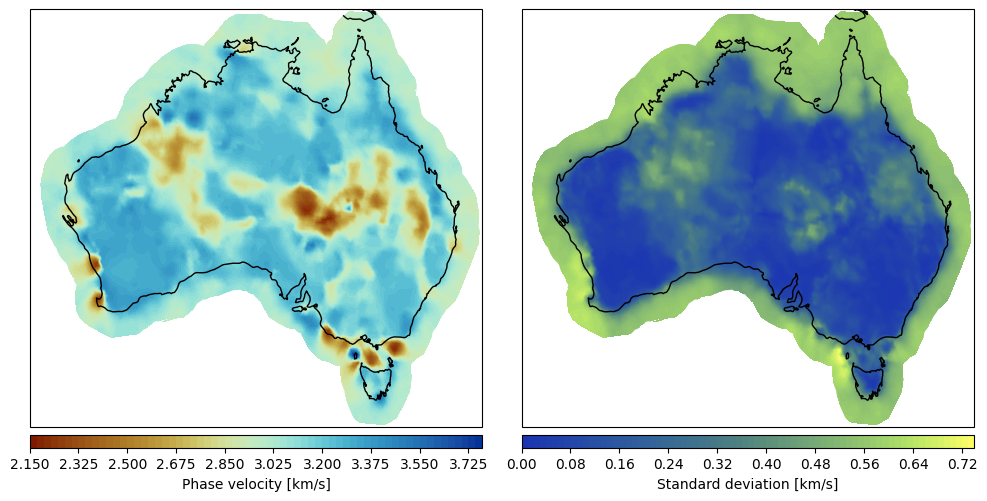

In [18]:
fig = plt.figure(figsize=(10, 6.5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
img = ax1.tricontourf(triang, 
                      inferred_vel, 
                      levels=75, 
                      cmap=scm.roma, 
                      transform=transform)
cbar = make_colorbar(ax1, img, orientation='horizontal', size='3%', pad='2%')
cbar.set_label('Phase velocity [km/s]')

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
img = ax2.tricontourf(triang, 
                      inferred_std, 
                      levels=75, 
                      cmap=scm.imola, 
                      transform=transform)
cbar = make_colorbar(ax2, img, orientation='horizontal', size='3%', pad='2%')
cbar.set_label('Standard deviation [km/s]')


for ax in [ax1, ax2]:
    ax.coastlines()
    ax.set_extent(map_boundaries, crs=transform)
    ax.add_patch(PathPatch(path, 
                           facecolor='white', 
                           edgecolor='none', 
                           transform=transform, 
                           zorder=2))
plt.tight_layout()   
plt.show()

----
## Watermark

In [1]:
watermark_list = ["bayesbay", "cofi", "espresso", "numpy", "matplotlib", "scipy", "seislib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

bayesbay 0.3.1
cofi 0.2.9
espresso 0.3.14
numpy 1.26.3
matplotlib 3.7.2
scipy 1.11.1
seislib 0.6.27
